In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER


In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14, 24)
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 14, 24)

In [6]:
t_all.shape

(52, 7, 14, 24)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM, Lambda
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Conv1D, Dense, Flatten, MaxPool1D, InputLayer, Activation, Dropout, MaxPooling1D


import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

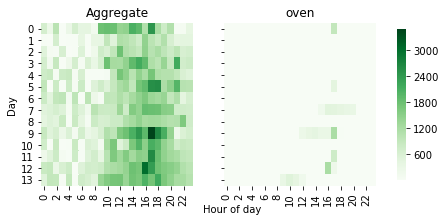

In [10]:
import seaborn as sns
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6,3))
cbar_ax = fig.add_axes([.95, 0.15, .02, .7])
home = 4
appliance_num = 6
sns.heatmap(t_all[home, 0, :, :],cmap='Greens',ax=ax[0],cbar_ax=None,cbar=False)
sns.heatmap(t_all[home, appliance_num, :, :],cmap='Greens',ax=ax[1],cbar_ax=cbar_ax,vmax=t_all[home, 0, :, :].max())
ax[0].set_title("Aggregate")
ax[1].set_title(APPLIANCES_ORDER[appliance_num])
ax[0].set_ylabel("Day")
fig.text(0.5, 0, "Hour of day")


In [11]:
num_days = 14
num_hours = 24

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K

aggregate = Input(shape=(num_days, num_hours, 1),name='Aggregate')  # adapt this if using `channels_first` image data format
def scale(x, con):
    return x/con

aggregate_norm = Lambda(scale, arguments={'con':5000})(aggregate)

hvac_conv = Conv2D(8, (14, 1), activation='relu', padding='same',name='HVAC-CONV')(aggregate_norm)
hvac_deconv = Conv2D(1, (1,24), activation='relu', padding='same',name='HVAC-deconv')(hvac_conv)

autoencoder = Model(aggregate, hvac_deconv)
from keras.optimizers import Adam


In [13]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Aggregate (InputLayer)       (None, 14, 24, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 14, 24, 1)         0         
_________________________________________________________________
HVAC-CONV (Conv2D)           (None, 14, 24, 8)         120       
_________________________________________________________________
HVAC-deconv (Conv2D)         (None, 14, 24, 1)         193       
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


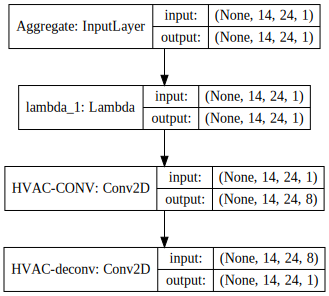

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(autoencoder,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [15]:
autoencoder = Model(aggregate, hvac_deconv)
appliance_num=1
print(APPLIANCES_ORDER[appliance_num])

hvac


In [16]:
maxs = {appliance_num:t_all[:30, appliance_num, :, :].max() for appliance_num in range(7)}

In [17]:
maxs

{0: 5000.416633605957,
 1: 3963.88330078125,
 2: 288.85000610351562,
 3: 960.7833251953125,
 4: 1122.300048828125,
 5: 498.43331909179688,
 6: 2914.800048828125}

In [18]:
agg.shape, maxs[0]

NameError: name 'agg' is not defined

In [103]:
autoencoder = Model(aggregate, hvac_deconv)


autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
agg = (t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1))/maxs[0]
appl = (t_all[:30, appliance_num, :, :].reshape(-1, num_days, num_hours,1) /maxs[appliance_num])
autoencoder.fit(agg, appl
                ,validation_split=0.1,epochs=500)

Train on 27 samples, validate on 3 samples
Epoch 1/500
27/27 [==============================] - 0s 10ms/step - loss: 0.1259 - val_loss: 0.1510
Epoch 2/500
27/27 [==============================] - 0s 513us/step - loss: 0.1259 - val_loss: 0.1510
Epoch 3/500
27/27 [==============================] - 0s 399us/step - loss: 0.1259 - val_loss: 0.1509
Epoch 4/500
27/27 [==============================] - 0s 487us/step - loss: 0.1259 - val_loss: 0.1509
Epoch 5/500
27/27 [==============================] - 0s 445us/step - loss: 0.1259 - val_loss: 0.1508
Epoch 6/500
27/27 [==============================] - 0s 468us/step - loss: 0.1259 - val_loss: 0.1508
Epoch 7/500
27/27 [==============================] - 0s 460us/step - loss: 0.1259 - val_loss: 0.1507
Epoch 8/500
27/27 [==============================] - 0s 454us/step - loss: 0.1259 - val_loss: 0.1507
Epoch 9/500
27/27 [==============================] - 0s 474us/step - loss: 0.1259 - val_loss: 0.1507
Epoch 10/500
27/27 [=============================

Epoch 81/500
27/27 [==============================] - 0s 472us/step - loss: 0.1256 - val_loss: 0.1497
Epoch 82/500
27/27 [==============================] - 0s 498us/step - loss: 0.1256 - val_loss: 0.1497
Epoch 83/500
27/27 [==============================] - 0s 547us/step - loss: 0.1256 - val_loss: 0.1497
Epoch 84/500
27/27 [==============================] - 0s 540us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 85/500
27/27 [==============================] - 0s 571us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 86/500
27/27 [==============================] - 0s 552us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 87/500
27/27 [==============================] - 0s 543us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 88/500
27/27 [==============================] - 0s 493us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 89/500
27/27 [==============================] - 0s 525us/step - loss: 0.1256 - val_loss: 0.1496
Epoch 90/500
27/27 [==============================] - 0s 540us/step - loss: 0.1256

Epoch 161/500
27/27 [==============================] - 0s 519us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 162/500
27/27 [==============================] - 0s 501us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 163/500
27/27 [==============================] - 0s 503us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 164/500
27/27 [==============================] - 0s 504us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 165/500
27/27 [==============================] - 0s 469us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 166/500
27/27 [==============================] - 0s 471us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 167/500
27/27 [==============================] - 0s 464us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 168/500
27/27 [==============================] - 0s 441us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 169/500
27/27 [==============================] - 0s 482us/step - loss: 0.1255 - val_loss: 0.1491
Epoch 170/500
27/27 [==============================] - 0s 490us/step - lo

Epoch 241/500
27/27 [==============================] - 0s 587us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 242/500
27/27 [==============================] - 0s 556us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 243/500
27/27 [==============================] - 0s 510us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 244/500
27/27 [==============================] - 0s 503us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 245/500
27/27 [==============================] - 0s 505us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 246/500
27/27 [==============================] - 0s 485us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 247/500
27/27 [==============================] - 0s 491us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 248/500
27/27 [==============================] - 0s 485us/step - loss: 0.1255 - val_loss: 0.1489
Epoch 249/500
27/27 [==============================] - 0s 543us/step - loss: 0.1254 - val_loss: 0.1489
Epoch 250/500
27/27 [==============================] - 0s 573us/step - lo

Epoch 321/500
27/27 [==============================] - 0s 539us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 322/500
27/27 [==============================] - 0s 520us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 323/500
27/27 [==============================] - 0s 499us/step - loss: 0.1254 - val_loss: 0.1489
Epoch 324/500
27/27 [==============================] - 0s 462us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 325/500
27/27 [==============================] - 0s 485us/step - loss: 0.1254 - val_loss: 0.1489
Epoch 326/500
27/27 [==============================] - 0s 468us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 327/500
27/27 [==============================] - 0s 465us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 328/500
27/27 [==============================] - 0s 478us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 329/500
27/27 [==============================] - 0s 489us/step - loss: 0.1254 - val_loss: 0.1488
Epoch 330/500
27/27 [==============================] - 0s 507us/step - lo

Epoch 401/500
27/27 [==============================] - 0s 454us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 402/500
27/27 [==============================] - 0s 493us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 403/500
27/27 [==============================] - 0s 465us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 404/500
27/27 [==============================] - 0s 460us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 405/500
27/27 [==============================] - 0s 491us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 406/500
27/27 [==============================] - 0s 446us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 407/500
27/27 [==============================] - 0s 452us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 408/500
27/27 [==============================] - 0s 486us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 409/500
27/27 [==============================] - 0s 473us/step - loss: 0.1253 - val_loss: 0.1487
Epoch 410/500
27/27 [==============================] - 0s 489us/step - lo

Epoch 481/500
27/27 [==============================] - 0s 397us/step - loss: 0.1252 - val_loss: 0.1486
Epoch 482/500
27/27 [==============================] - 0s 433us/step - loss: 0.1252 - val_loss: 0.1486
Epoch 483/500
27/27 [==============================] - 0s 410us/step - loss: 0.1252 - val_loss: 0.1485
Epoch 484/500
27/27 [==============================] - 0s 423us/step - loss: 0.1252 - val_loss: 0.1486
Epoch 485/500
27/27 [==============================] - 0s 393us/step - loss: 0.1252 - val_loss: 0.1485
Epoch 486/500
27/27 [==============================] - 0s 411us/step - loss: 0.1252 - val_loss: 0.1486
Epoch 487/500
27/27 [==============================] - 0s 398us/step - loss: 0.1252 - val_loss: 0.1485
Epoch 488/500
27/27 [==============================] - 0s 401us/step - loss: 0.1251 - val_loss: 0.1486
Epoch 489/500
27/27 [==============================] - 0s 406us/step - loss: 0.1251 - val_loss: 0.1485
Epoch 490/500
27/27 [==============================] - 0s 428us/step - lo

In [96]:
pred = autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()

In [97]:
pred.shape, (t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).shape

((22, 14, 24), (30, 14, 24, 1))

In [98]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fl, pred_fl)

932.12410719348748

In [99]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

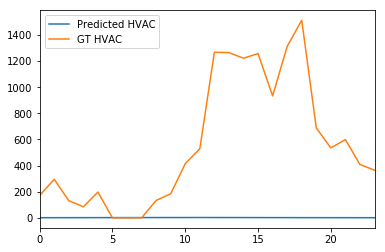

In [100]:
pred_overall_appliance = (1*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0])).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
#pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-cnn.png")

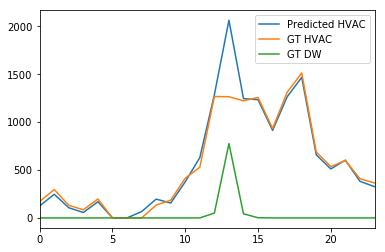

In [359]:
pred_overall_appliance = (maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0])).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-dw-cnn.png")

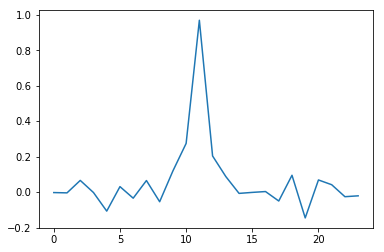

In [266]:
plt.plot(autoencoder.layers[2].get_weights()[0].flatten())

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [11]:
train_hvac.shape

NameError: name 'train_hvac' is not defined

In [12]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

NameError: name 'train_hvac' is not defined

In [80]:
#pred_appliance = {}
sequence_length=24
num_iterations_dictionary = {'hvac':400,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[2:]:


    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    model = Sequential()
    filters=20
    kernel_size=2
    model.add(InputLayer(input_shape=(sequence_length,1)))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=1 ,name='C1'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))
    model.add(Conv1D(filters=20,
                     kernel_size=5,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=25,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=30,
                     kernel_size=2,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(sequence_length, activation='relu'))
    model.add(Dropout(rate=0.1))


    model.compile('adam','mean_absolute_error')
    model.fit(train_agg.reshape(-1, 24, 1), train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg.reshape(-1,24,1))



fridge
********************
Train on 378 samples, validate on 42 samples
Epoch 1/500
378/378 [==============================] - 1s 3ms/step - loss: 104.0335 - val_loss: 80.1024
Epoch 2/500
378/378 [==============================] - 0s 128us/step - loss: 73.5439 - val_loss: 82.9650
Epoch 3/500
378/378 [==============================] - 0s 120us/step - loss: 69.5276 - val_loss: 71.1884
Epoch 4/500
378/378 [==============================] - 0s 124us/step - loss: 65.7872 - val_loss: 66.9487
Epoch 5/500
378/378 [==============================] - 0s 123us/step - loss: 61.5952 - val_loss: 60.5597
Epoch 6/500
378/378 [==============================] - 0s 121us/step - loss: 57.9371 - val_loss: 58.2805
Epoch 7/500
378/378 [==============================] - 0s 123us/step - loss: 54.5536 - val_loss: 53.5956
Epoch 8/500
378/378 [==============================] - 0s 116us/step - loss: 52.0083 - val_loss: 48.1487
Epoch 9/500
378/378 [==============================] - 0s 110us/step - loss: 49.8050 - v

Epoch 154/500
378/378 [==============================] - 0s 112us/step - loss: 36.6051 - val_loss: 40.9227
Epoch 155/500
378/378 [==============================] - 0s 114us/step - loss: 36.8613 - val_loss: 37.9792
Epoch 156/500
378/378 [==============================] - 0s 118us/step - loss: 36.0987 - val_loss: 39.7679
Epoch 157/500
378/378 [==============================] - 0s 114us/step - loss: 35.8294 - val_loss: 40.1168
Epoch 158/500
378/378 [==============================] - 0s 112us/step - loss: 35.9135 - val_loss: 40.3052
Epoch 159/500
378/378 [==============================] - 0s 113us/step - loss: 35.9357 - val_loss: 41.5186
Epoch 160/500
378/378 [==============================] - 0s 116us/step - loss: 36.4006 - val_loss: 42.6061
Epoch 161/500
378/378 [==============================] - 0s 112us/step - loss: 36.0867 - val_loss: 39.4884
Epoch 162/500
378/378 [==============================] - 0s 120us/step - loss: 36.2109 - val_loss: 40.9371
Epoch 163/500
378/378 [==============

378/378 [==============================] - 0s 112us/step - loss: 31.1762 - val_loss: 39.1932
Epoch 307/500
378/378 [==============================] - 0s 124us/step - loss: 31.3601 - val_loss: 40.4758
Epoch 308/500
378/378 [==============================] - 0s 116us/step - loss: 30.9723 - val_loss: 39.7988
Epoch 309/500
378/378 [==============================] - 0s 115us/step - loss: 31.2240 - val_loss: 39.2697
Epoch 310/500
378/378 [==============================] - 0s 115us/step - loss: 31.3497 - val_loss: 39.5279
Epoch 311/500
378/378 [==============================] - 0s 122us/step - loss: 31.1582 - val_loss: 39.6884
Epoch 312/500
378/378 [==============================] - 0s 117us/step - loss: 31.5861 - val_loss: 40.0486
Epoch 313/500
378/378 [==============================] - 0s 113us/step - loss: 31.2570 - val_loss: 38.6425
Epoch 314/500
378/378 [==============================] - 0s 114us/step - loss: 31.3038 - val_loss: 40.4669
Epoch 315/500
378/378 [============================

378/378 [==============================] - 0s 117us/step - loss: 30.3796 - val_loss: 40.3136
Epoch 459/500
378/378 [==============================] - 0s 113us/step - loss: 30.4188 - val_loss: 39.4738
Epoch 460/500
378/378 [==============================] - 0s 134us/step - loss: 30.3670 - val_loss: 41.0653
Epoch 461/500
378/378 [==============================] - 0s 139us/step - loss: 31.0115 - val_loss: 40.8251
Epoch 462/500
378/378 [==============================] - 0s 148us/step - loss: 29.9184 - val_loss: 39.8697
Epoch 463/500
378/378 [==============================] - 0s 142us/step - loss: 30.1677 - val_loss: 40.4435
Epoch 464/500
378/378 [==============================] - 0s 109us/step - loss: 30.2846 - val_loss: 39.8982
Epoch 465/500
378/378 [==============================] - 0s 118us/step - loss: 30.1463 - val_loss: 40.1937
Epoch 466/500
378/378 [==============================] - 0s 122us/step - loss: 30.7215 - val_loss: 39.5725
Epoch 467/500
378/378 [============================

378/378 [==============================] - 0s 121us/step - loss: 6.3622 - val_loss: 8.3305
Epoch 36/250
378/378 [==============================] - 0s 114us/step - loss: 6.3444 - val_loss: 8.3305
Epoch 37/250
378/378 [==============================] - 0s 118us/step - loss: 6.3139 - val_loss: 8.3305
Epoch 38/250
378/378 [==============================] - 0s 116us/step - loss: 6.3362 - val_loss: 8.3305
Epoch 39/250
378/378 [==============================] - 0s 125us/step - loss: 6.3247 - val_loss: 8.3305
Epoch 40/250
378/378 [==============================] - 0s 116us/step - loss: 6.3242 - val_loss: 8.3305
Epoch 41/250
378/378 [==============================] - 0s 118us/step - loss: 6.3202 - val_loss: 8.3305
Epoch 42/250
378/378 [==============================] - 0s 117us/step - loss: 6.3161 - val_loss: 8.3305
Epoch 43/250
378/378 [==============================] - 0s 116us/step - loss: 6.3093 - val_loss: 8.3305
Epoch 44/250
378/378 [==============================] - 0s 121us/step - loss:

Epoch 114/250
378/378 [==============================] - 0s 117us/step - loss: 6.3000 - val_loss: 8.3305
Epoch 115/250
378/378 [==============================] - 0s 111us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 116/250
378/378 [==============================] - 0s 113us/step - loss: 6.3038 - val_loss: 8.3305
Epoch 117/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 118/250
378/378 [==============================] - 0s 123us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 119/250
378/378 [==============================] - 0s 121us/step - loss: 6.3047 - val_loss: 8.3305
Epoch 120/250
378/378 [==============================] - 0s 114us/step - loss: 6.3041 - val_loss: 8.3305
Epoch 121/250
378/378 [==============================] - 0s 114us/step - loss: 6.3017 - val_loss: 8.3305
Epoch 122/250
378/378 [==============================] - 0s 113us/step - loss: 6.3045 - val_loss: 8.3305
Epoch 123/250
378/378 [==============================] 

378/378 [==============================] - 0s 129us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 193/250
378/378 [==============================] - 0s 115us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 194/250
378/378 [==============================] - 0s 115us/step - loss: 6.3023 - val_loss: 8.3305
Epoch 195/250
378/378 [==============================] - 0s 116us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 196/250
378/378 [==============================] - 0s 115us/step - loss: 6.2995 - val_loss: 8.3305
Epoch 197/250
378/378 [==============================] - 0s 117us/step - loss: 6.3016 - val_loss: 8.3305
Epoch 198/250
378/378 [==============================] - 0s 125us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 199/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 200/250
378/378 [==============================] - 0s 116us/step - loss: 6.3010 - val_loss: 8.3305
Epoch 201/250
378/378 [==============================] - 0s 124us/ste

378/378 [==============================] - 0s 126us/step - loss: 13.4612 - val_loss: 15.0648
Epoch 97/250
378/378 [==============================] - 0s 118us/step - loss: 13.4559 - val_loss: 15.0648
Epoch 98/250
378/378 [==============================] - 0s 129us/step - loss: 13.4462 - val_loss: 15.0648
Epoch 99/250
378/378 [==============================] - 0s 121us/step - loss: 13.4459 - val_loss: 15.0648
Epoch 100/250
378/378 [==============================] - 0s 124us/step - loss: 13.4473 - val_loss: 15.0648
Epoch 101/250
378/378 [==============================] - 0s 125us/step - loss: 13.4471 - val_loss: 15.0648
Epoch 102/250
378/378 [==============================] - 0s 124us/step - loss: 13.4526 - val_loss: 15.0648
Epoch 103/250
378/378 [==============================] - 0s 124us/step - loss: 13.4521 - val_loss: 15.0648
Epoch 104/250
378/378 [==============================] - 0s 129us/step - loss: 13.4508 - val_loss: 15.0648
Epoch 105/250
378/378 [==============================]

378/378 [==============================] - 0s 128us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 249/250
378/378 [==============================] - 0s 120us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 250/250
378/378 [==============================] - 0s 113us/step - loss: 13.4452 - val_loss: 15.0648
wm
********************
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 1s 3ms/step - loss: 83.1399 - val_loss: 17.0875
Epoch 2/300
378/378 [==============================] - 0s 129us/step - loss: 15.5730 - val_loss: 5.7701
Epoch 3/300
378/378 [==============================] - 0s 125us/step - loss: 7.4662 - val_loss: 4.5463
Epoch 4/300
378/378 [==============================] - 0s 128us/step - loss: 6.1663 - val_loss: 4.3702
Epoch 5/300
378/378 [==============================] - 0s 128us/step - loss: 5.5833 - val_loss: 4.3453
Epoch 6/300
378/378 [==============================] - 0s 124us/step - loss: 5.3496 - val_loss: 4.3410
Epoch

378/378 [==============================] - 0s 119us/step - loss: 4.7265 - val_loss: 4.3410
Epoch 155/300
378/378 [==============================] - 0s 127us/step - loss: 4.7330 - val_loss: 4.3410
Epoch 156/300
378/378 [==============================] - 0s 117us/step - loss: 4.7379 - val_loss: 4.3410
Epoch 157/300
378/378 [==============================] - 0s 130us/step - loss: 4.7319 - val_loss: 4.3410
Epoch 158/300
378/378 [==============================] - 0s 128us/step - loss: 4.7332 - val_loss: 4.3410
Epoch 159/300
378/378 [==============================] - 0s 136us/step - loss: 4.7318 - val_loss: 4.3410
Epoch 160/300
378/378 [==============================] - 0s 129us/step - loss: 4.7411 - val_loss: 4.3410
Epoch 161/300
378/378 [==============================] - 0s 122us/step - loss: 4.7391 - val_loss: 4.3410
Epoch 162/300
378/378 [==============================] - 0s 119us/step - loss: 4.7347 - val_loss: 4.3410
Epoch 163/300
378/378 [==============================] - 0s 126us/ste

378/378 [==============================] - 0s 134us/step - loss: 14.6388 - val_loss: 13.5292
Epoch 10/250
378/378 [==============================] - 0s 125us/step - loss: 14.5970 - val_loss: 13.5281
Epoch 11/250
378/378 [==============================] - 0s 134us/step - loss: 14.5895 - val_loss: 13.5295
Epoch 12/250
378/378 [==============================] - 0s 124us/step - loss: 14.5554 - val_loss: 13.5289
Epoch 13/250
378/378 [==============================] - 0s 133us/step - loss: 14.5966 - val_loss: 13.5239
Epoch 14/250
378/378 [==============================] - 0s 135us/step - loss: 14.5681 - val_loss: 13.5176
Epoch 15/250
378/378 [==============================] - 0s 133us/step - loss: 14.5617 - val_loss: 13.5187
Epoch 16/250
378/378 [==============================] - 0s 124us/step - loss: 14.5268 - val_loss: 13.5165
Epoch 17/250
378/378 [==============================] - 0s 123us/step - loss: 14.5224 - val_loss: 13.5165
Epoch 18/250
378/378 [==============================] - 0s 

Epoch 86/250
378/378 [==============================] - 0s 121us/step - loss: 14.4617 - val_loss: 13.5180
Epoch 87/250
378/378 [==============================] - 0s 134us/step - loss: 14.4544 - val_loss: 13.5179
Epoch 88/250
378/378 [==============================] - 0s 122us/step - loss: 14.4448 - val_loss: 13.5183
Epoch 89/250
378/378 [==============================] - 0s 129us/step - loss: 14.4630 - val_loss: 13.5165
Epoch 90/250
378/378 [==============================] - 0s 132us/step - loss: 14.4542 - val_loss: 13.5165
Epoch 91/250
378/378 [==============================] - 0s 131us/step - loss: 14.4567 - val_loss: 13.5181
Epoch 92/250
378/378 [==============================] - 0s 134us/step - loss: 14.4473 - val_loss: 13.5075
Epoch 93/250
378/378 [==============================] - 0s 121us/step - loss: 14.4660 - val_loss: 13.5007
Epoch 94/250
378/378 [==============================] - 0s 132us/step - loss: 14.4361 - val_loss: 13.5165
Epoch 95/250
378/378 [========================

378/378 [==============================] - 0s 131us/step - loss: 12.7644 - val_loss: 12.3515
Epoch 239/250
378/378 [==============================] - 0s 133us/step - loss: 12.8034 - val_loss: 12.4435
Epoch 240/250
378/378 [==============================] - 0s 119us/step - loss: 12.6870 - val_loss: 12.4177
Epoch 241/250
378/378 [==============================] - 0s 128us/step - loss: 12.7014 - val_loss: 12.5220
Epoch 242/250
378/378 [==============================] - 0s 132us/step - loss: 12.6575 - val_loss: 12.5753
Epoch 243/250
378/378 [==============================] - 0s 122us/step - loss: 12.7996 - val_loss: 12.5444
Epoch 244/250
378/378 [==============================] - ETA: 0s - loss: 10.83 - 0s 128us/step - loss: 12.7116 - val_loss: 12.3564
Epoch 245/250
378/378 [==============================] - 0s 137us/step - loss: 12.6985 - val_loss: 12.5121
Epoch 246/250
378/378 [==============================] - 0s 130us/step - loss: 12.6630 - val_loss: 12.5820
Epoch 247/250
378/378 [====

In [25]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 24, 1)             0         
_________________________________________________________________
C1 (Conv1D)                  (None, 24, 20)            220       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 12, 20)            0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 12, 20)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 12, 20)            2020      
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 6, 20)             0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 6, 20)             0         
__________

In [81]:
from sklearn.metrics import mean_absolute_error
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    try:
        mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    except Exception as e:
        print(e)
    
    

In [82]:
pd.Series(mae)

dw         14.499116
fridge     34.620154
hvac      331.035001
mw          6.300214
oven       18.633957
wm          5.617521
dtype: float64

In [83]:
pd.Series(mae)

dw         14.499116
fridge     34.620154
hvac      331.035001
mw          6.300214
oven       18.633957
wm          5.617521
dtype: float64

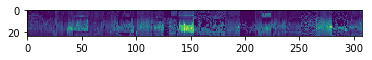

In [84]:
plt.imshow(test_agg.T)

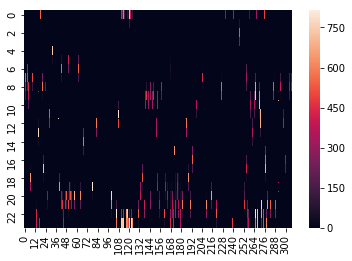

In [85]:
import seaborn as sns
sns.heatmap(test_appliance['dw'].T)

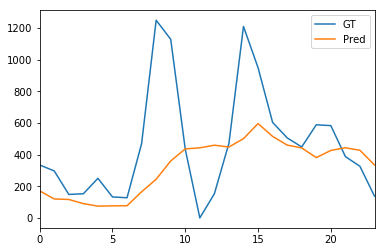

In [93]:
pd.Series(test_appliance['hvac'][14]).plot(label='GT')

pd.Series(pred_appliance['hvac'][14]).plot(label='Pred')
plt.legend()

In [2]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




NameError: name 'model' is not defined

In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

In [1]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()

NameError: name 'pd' is not defined